### Data Mining and Machine Learning

### Feature Selection in Supervised Classification
#### Edgar Acuna

Use of modules: feature_selection from scikit-learn, feature selection from Arizona State University and skrebate 


In [1]:
import pandas as pd
import numpy as np
import math as m
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, SelectPercentile, f_classif, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\edgar2017\Anaconda2\envs\ipykernel_py2\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


Loading the Diabetes dataset

In [2]:
url= "http://academic.uprm.edu/eacuna/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names,header=None)
y=data['class']
X=data.iloc[:,0:8]

### I. Feature Selection by Visualization

In [3]:
print(data.shape)
data.head()
#normalizando los datos
data1=data.drop('class',axis=1)
data1_norm=(data1 - data1.min()) / (data1.max() - data1.min())
data1_norm['class']=data['class']

(768, 9)


C:\Users\edgar2017\Anaconda2\envs\ipykernel_py2\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


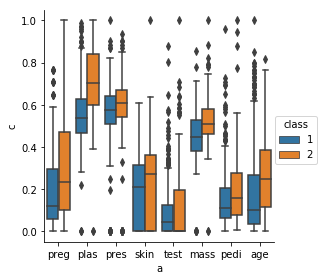

In [4]:
plt.figure(figsize=(10,50))
df_long = pd.melt(data1_norm, "class", var_name="a", value_name="c")
sns.factorplot("a", hue="class", y="c", data=df_long, kind="box")

Comment: From the boxplots we can see  that features: plas, age,preg,press and mass have boxplot not so overlaped

### II-Using the Chi-Square test  for choosing the best features
It is desirable to have discretizaed attributes and two classes. I do not recommend 
to use this method because the Chi-Square test is approximated and it is not robust.

In [5]:
y=data['class']
X=data.iloc[:,0:8]

In [6]:
# Funcion auxiliar para discretizar cualquier columna de un dataframe
def disc_col_ew(df,str,k,out):
    df1=df[str]
    bins=np.linspace(df1.min(), df1.max(),k)
    if out=="num":
        df1=pd.cut(df1,bins=bins,include_lowest=True, right=True,labels=False)
    else:
        bins[0]=float('-inf')
        bins[k-1]=float('inf')
        df1=pd.cut(df1,bins=bins,include_lowest=True, right=True)  
    return df1
# funcion auxiliar para determinar el numero optimo de intervalos segun la formula de scott
def nclass_scott(x):
    h=3.5*(np.var(x,ddof=1)**.5)*len(x)**(-.3333)
    intervals=m.ceil((max(x)-min(x))/h)
    return int(intervals)

In [7]:
#Funcion para discretizar todas las colunmnas de un dataframe
def disc_ew(df,out):
    name=df.columns.tolist()
    disc=pd.DataFrame()
    for name in df.columns.tolist():
        k=nclass_scott(df[name])
        disc[name]=disc_col_ew(df,name,k,out)
    return disc

In [8]:
#discretizando las columnas de la matriz predictora X de diabetes
diab_disc=disc_ew(X,out="num")

In [9]:
y1=y.as_matrix()
X1=diab_disc.as_matrix()
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X1, y1)
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
features= fit.transform(X1)
# Imprime los datos de las tres mejores features
print(features)

[ 105.387  120.206    2.87    10.086   59.232   42.746   62.639  115.924]
[[ 4 11  6]
 [ 0  6  2]
 [ 6 14  2]
 ..., 
 [ 3  9  1]
 [ 0 10  5]
 [ 0  7  0]]


Comentario: Las tres mejores variables con la prueba de Chi-square son plas, age y preg por tener el Chi-Square mas alto.

### III-Using the F test to find the best features  

Se puede usar la libreria sciki-learn o la libreria de la ASU

In [10]:
# Selecion  de Features usando los p-values de la F-test como score
# Aqui usamos sciji-learn y se selecciona el 30% de deatures con el mas alro score
selector = SelectPercentile(f_classif, percentile=30)
fit=selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
print(scores)
features= fit.transform(X)
# Imprime los datos de las tres mejores features
print(features)

[ 0.221  1.     0.027  0.034  0.084  0.378  0.14   0.253]
[[ 148.    33.6   50. ]
 [  85.    26.6   31. ]
 [ 183.    23.3   32. ]
 ..., 
 [ 121.    26.2   30. ]
 [ 126.    30.1   47. ]
 [  93.    30.4   23. ]]


Comentario: Las tres, mejores variables con la prueba de F son plas,mass y age

In [11]:
#Usando la libreria Feature selection de la ASU
features, labels = X.values, data['class'].values
X_train, X_test, y_train, y_test = train_test_split(features, labels)
from skfeature.function.statistical_based import f_score
scoref = f_score.f_score(X_train, y_train)
idx = f_score.feature_ranking(scoref)
print(scoref,idx)

(array([  26.325,  146.309,    1.552,    1.212,    8.309,   54.771,
         15.916,   33.079]), array([1, 5, 7, 0, 6, 4, 2, 3], dtype=int64))


Comentario: las tres variables mas importantes con la prueba de F son: plas,mass y age

### IV- Usando Mutual Information (Entropia)

Libreria scikit-learn


In [12]:
# Univariate feature selection with Mutual Information
scores = mutual_info_classif(X,y)
scores /= scores.max()
print(scores)

[ 0.254  1.     0.01   0.     0.169  0.589  0.117  0.369]



Comentario: Las tres variables usando el criterio de Mutual Information son: plas, mass y age

### V-Using ReliefF to select the best features 

Module: skrebate 

In [13]:
from skrebate import ReliefF
from sklearn.model_selection import train_test_split

df=data.drop('class',axis=1)
#Normalizando las predictoras
df_norm=(df - df.min()) / (df.max() - df.min())
features, labels = df_norm.values, data['class'].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, labels)

fs = ReliefF(n_neighbors=10)
fs.fit(X_train, y_train)

for feature_name, feature_score in zip(df.columns,fs.feature_importances_):
    print (feature_name, feature_score)

('preg', 41.941176470588303)
('plas', 77.153266331658301)
('pres', 11.049180327868855)
('skin', 39.434343434343468)
('test', 13.597517730496454)
('mass', 51.636363636363626)
('pedi', 20.821603563474383)
('age', 36.649999999999977)


Comentario: las tres variables mas importantes con el ReliefF son: plas,mass y skin

ReliefF using the feature selection module form the ASU

In [15]:
from skfeature.function.similarity_based import reliefF
score_relief=reliefF.reliefF(X_train,y_train)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

(array([  8.165,  15.155,   2.492,   7.756,   1.452,  11.929,   2.585,   6.8  ]), array([1, 5, 0, 3, 7, 6, 2, 4], dtype=int64))


 Comentario: las tres variables mas importantes con el RelieF son: plas, mass y skin
 
 Using Relief from Orange

In [16]:
import Orange
df = Orange.data.Table("diabetes")

def print_best_3(ma):
    for m in ma[:3]:
        print "%5.3f %s" % (m[1], m[0])

print 'Feature scores for best three features (scored individually):'
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m-100 para updating de los pesos
meas = Orange.feature.scoring.Relief(k=10, m=100)
mr = [ (a.name, meas(a, df)) for a in df.domain.attributes]
mr.sort(key=lambda x: -x[1]) #sort decreasingly by the score
print_best_3(mr)


Feature scores for best three features (scored individually):
0.036 plas
0.026 age
0.015 mass


Example 2:

Loading the Bupa dataset

In [17]:
# Usando el reliefF de la ASU
#load data
url= "http://academic.uprm.edu/eacuna/bupa.dat"
names = ['mcv', 'alkphos', 'sgpt', 'aspar', 'gammagt', 'drinks', 'class']
data = pd.read_table(url, names=names,header=None)
y=data['class']
X=data.iloc[:,0:6]
y1=y.as_matrix()
X1=X.as_matrix()
features, labels = X.values, data['class'].values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, labels)
score_relief=reliefF.reliefF(X_train,y_train)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

(array([   6.6,  231.8,  310.6,  132.6,   43.4,   30.1]), array([2, 1, 3, 4, 5, 0], dtype=int64))


El Rielief de ASU recomienda sgpt,aspar y drinks como las mejoras predictoras

In [19]:
fs = ReliefF(n_neighbors=10)
fs.fit(X_train, y_train)

for feature_name, feature_score in zip(data.columns,fs.feature_importances_):
    print (feature_name, feature_score)

('mcv', 5.2368421052631557)
('alkphos', 1.1000000000000019)
('sgpt', 7.804635761589406)
('aspar', 6.727272727272724)
('gammagt', 7.4840909090909076)
('drinks', 4.9375)


El relielf de skrebate recomienda gammagt, sgpt y drinks

Example 3: 

Applying ReliefF to Breast-cancer-Wisconsin

In [20]:
data = pd.read_table("c://PW-PR/breast-cancer-wisconsin.data", header=None,sep=",",na_values="?")
data=data.fillna(data.mean())
y=data.iloc[:,10]
X=data.iloc[:,1:10]
y1=y.as_matrix()
X1=X.as_matrix()
features, labels = X.values, y.values
X_train, X_test, y_train, y_test = train_test_split(features, labels)

In [21]:
#usando Relief de la ASU
score_relief=reliefF.reliefF(X_train,y_train)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

(array([ 1150.4 ,   621.  ,   669.6 ,   438.4 ,   271.4 ,  1242.48,
         498.6 ,   705.  ,   266.6 ]), array([5, 0, 7, 2, 1, 6, 3, 4, 8], dtype=int64))


Comment:The best attributes are:6(Bare Nuclei),1 (Clump Thickness),8 (Normal. nucleoli),3 (Uniformity of Cell Shape),2  (Uniformity of Cell Size)

In [22]:
#Usando el Relief de Orange
import Orange
df = Orange.data.Table("breast-cancer-wisconsin-disc.tab")
def print_best_5(ma):
    for m in ma[:5]:
        print "%5.3f %s" % (m[1], m[0])

print 'Feature scores for best three features (scored individually):'
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=400 para updating de los pesos
meas = Orange.feature.scoring.Relief(k=1, m=400)
mr = [ (a.name, meas(a, df)) for a in df.domain.attributes[0:9]]
mr.sort(key=lambda x: -x[1]) #sort decreasingly by the score
print_best_5(mr)


Feature scores for best three features (scored individually):
0.472 Bare Nuclei
0.423 Clump Thickness
0.418 Normal Nucleoli
0.393 Uniformity of Cell Size
0.380 Uniformity of Cell Shape


Example 4: Landsat Dataset

In [23]:
url='http://academic.uprm.edu/eacuna/landsat.txt'
data = pd.read_table(url, header=None,delim_whitespace=True)
y=data.iloc[:,36]
X=data.iloc[:,0:36]
y1=y.as_matrix()
X1=X.as_matrix()
features, labels = X.values, y.values
X_train, X_test, y_train, y_test = train_test_split(features, labels)

### Using Relief from skfeature (ASU)

In [24]:
#usando Relief de la ASU
score_relief=reliefF.reliefF(X_train,y_train)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

(array([  946924.223,  1278867.01 ,   931537.206,  1086849.181,
         924011.349,  1244307.866,   833401.87 ,  1001762.501,
         989177.656,  1411298.129,   892765.962,  1220634.333,
        1004542.983,  1342843.924,   909126.102,  1108105.477,
         982955.797,  1282965.808,   860477.436,  1027568.201,
         989108.051,  1298078.58 ,   803141.333,  1039158.338,
        1012175.882,  1356452.944,   889238.532,  1124439.699,
         958137.038,  1288035.778,   816606.836,  1014124.387,
         942080.859,  1250405.175,   884559.658,  1083290.866]), array([ 9, 25, 13, 21, 29, 17,  1, 33,  5, 11, 27, 15,  3, 35, 23, 19, 31,
       24, 12,  7,  8, 20, 16, 28,  0, 32,  2,  4, 14, 10, 26, 34, 18,  6,
       30, 22], dtype=int64))


### Using Relief from Orange

In [25]:
#Usando el Relief de Orange
import Orange
df = Orange.data.Table("c://PW-PR/landsat.tab")

def print_best_10(ma):
    for m in ma[:10]:
        print "%5.3f %s" % (m[1], m[0])

print 'Feature scores for best ten features (scored individually):'
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=100 para updating de los pesos
meas = Orange.feature.scoring.Relief(k=10, m=100)
mr = [ (a.name, meas(a, df)) for a in df.domain.attributes]
mr.sort(key=lambda x: -x[1]) #sort decreasingly by the score
print_best_10(mr)


Feature scores for best ten features (scored individually):
0.125 a13
0.121 a25
0.120 a17
0.116 a1
0.115 a29
0.113 a33
0.113 a21
0.111 a5
0.108 a9
0.099 a14
